In [1]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jraf (jraf-universidade-federal-de-pernambuco). Use `wandb login --relogin` to force relogin


True

In [2]:
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# Initialize W&B
wandb.init(
    project="autoencoder_tcc",
    config={
        "patience": 5,
        "epochs": 250,
        "batch_size": 16,
        "encoding_dim": 512,
        "imgsz": 128
    }
)

2024-12-14 22:14:35.070557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734225275.945947   48077 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734225276.194183   48077 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 22:14:41.144480: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow as tf

print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from build import build_autoencoder

autoencoder, encoder = build_autoencoder(
    input_shape=(wandb.config.imgsz, wandb.config.imgsz, 3),
    encoding_dim=wandb.config.encoding_dim,
    batch_size=wandb.config.batch_size
)

I0000 00:00:1734225328.801463   48077 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
# Print model summary
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (16, 128, 128, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (16, 128, 128, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (16, 64, 64, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (16, 64, 64, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (16, 32, 32, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (16, 32, 32, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (16, 16, 16, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (16, 32768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 512)              │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 32768)            │    16,809,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (16, 16, 16, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (16, 32, 32, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (16, 64, 64, 64)       │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (16, 128, 128, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (16, 128, 128, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,921,667 (129.40 MB)

 Trainable params: 33,921,667 (129.40 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
import os

from tensorflow.keras.utils import image_dataset_from_directory

cwd = os.getcwd()
data_path = os.path.join(cwd, '..', '..', 'ships_v10i')
img_size = (wandb.config.imgsz, wandb.config.imgsz)

# Create directories for train data
images_dir = os.path.join(data_path, "cropped")

# Load dataset using image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    images_dir,
    labels=None,  # No labels as this is for autoencoder
    image_size=img_size,
    batch_size=wandb.config.batch_size,
    shuffle=True
)

to_autoencoder = lambda n: (n, n)


# Repeat the dataset for uninterrupted training
train_dataset = train_dataset.map(lambda x: to_autoencoder(x / 255.0))
repeatable_train_dataset = train_dataset.repeat()
# .prefetch(buffer_size=tf.data.AUTOTUNE)

Found 3406 files.


In [7]:
autoencoder.compile(optimizer="adam", loss="mse")

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Add EarlyStopping callback for patience
early_stopping = EarlyStopping(
    # Monitors training loss (you can switch to 'val_loss' if validation data is used)
    monitor="loss",
    patience=wandb.config.patience,
    restore_best_weights=True,  # Restores the best weights after stopping
    verbose=1
)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Directory to save the best model
save_dir = os.path.join(cwd, "best_model")
os.makedirs(save_dir, exist_ok=True)

# Path to save the best autoencoder model
best_autoencoder_path = os.path.join(save_dir, "best_autoencoder.keras")

# Callback to save the best model based on loss
checkpoint = ModelCheckpoint(
    filepath=best_autoencoder_path,
    monitor="loss",           # Metric to monitor
    save_best_only=True,      # Save only the best model
    save_weights_only=False,  # Save the entire model, not just weights
    verbose=1
)

In [11]:
total_images = len(os.listdir(images_dir))
steps_per_epoch = total_images // int(wandb.config.batch_size)

In [10]:
autoencoder.fit(
    repeatable_train_dataset,
    epochs=wandb.config.epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=1,
    callbacks=[
        WandbMetricsLogger(),
        checkpoint,
        # WandbModelCheckpoint("autoencoder.keras"),
        early_stopping,
    ],
)

Epoch 1/250


I0000 00:00:1734221330.371824   38042 service.cc:148] XLA service 0x7fb7e800ff80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734221330.372284   38042 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-12-14 21:08:50.576616: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734221330.938952   38042 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-14 21:08:52.240226: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_455', 188 bytes spill stores, 188 bytes spill loads



  7/212 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0666

I0000 00:00:1734221338.565169   38042 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


212/212 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - loss: 0.0425
Epoch 2/250


2024-12-14 21:09:18.896147: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_455', 196 bytes spill stores, 196 bytes spill loads

2024-12-14 21:09:24.412605: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=8,k3=0} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[14,32,64,64]{3,2,1,0}, f32[14,64,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-12-14 21:09:24.415881: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.955389507s
Trying algorithm eng20{k2=8,k3=0} for conv (f32[64,32,3

212/212 ━━━━━━━━━━━━━━━━━━━━ 29s 96ms/step - loss: 0.0121
Epoch 3/250
212/212 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - loss: 0.0096
Epoch 4/250
212/212 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - loss: 0.0078
Epoch 5/250
212/212 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - loss: 0.0069
Epoch 6/250
212/212 ━━━━━━━━━━━━━━━━━━━━ 24s 113ms/step - loss: 0.0063
Epoch 7/250
212/212 ━━━━━━━━━━━━━━━━━━━━ 25s 118ms/step - loss: 0.0052
Epoch 8/250
212/212 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - loss: 0.0044
Epoch 9/250
212/212 ━━━━━━━━━━━━━━━━━━━━ 28s 132ms/step - loss: 0.0042
Epoch 10/250
212/212 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - loss: 0.0039
Epoch 11/250
212/212 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - loss: 0.0037
Epoch 12/250
212/212 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - loss: 0.0036
Epoch 13/250
212/212 ━━━━━━━━━━━━━━━━━━━━ 25s 116ms/step - loss: 0.0034
Epoch 14/250
212/212 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.0034
Epoch 15/250
212/212 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - loss: 0.0030
Epoch 16/250
2

In [ ]:
# Directory to save the models
save_dir = os.path.join(cwd, "saved_models")
os.makedirs(save_dir, exist_ok=True)

# Paths to save autoencoder and encoder
autoencoder_save_path = os.path.join(save_dir, "autoencoder")
encoder_save_path = os.path.join(save_dir, "encoder")

# Save the autoencoder
autoencoder.save(autoencoder_save_path)  # TensorFlow SavedModel format
print(f"Autoencoder saved to {autoencoder_save_path}")

# Save the encoder
encoder.save(encoder_save_path)  # TensorFlow SavedModel format
print(f"Encoder saved to {encoder_save_path}")

In [11]:
# Finish the W&B run
wandb.finish()

epoch/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,62
epoch/learning_rate,0.001
epoch/loss,0.00112


In [12]:
from cluster import cluster_latent_space, plot_silhouette_scores

In [ ]:
# LOAD_MODEL = True
if LOAD_MODEL:
    from keras import Model
    autoencoder = tf.keras.models.load_model("v1_autoencoder.keras")
    autoencoder.summary()
    # Identify the layer that ends the encoder part.
    # According to the summary you provided, the encoder ends at the 'dense' layer.
    encoder_output_layer_name = "dense"  # Adjust if needed after checking the summary

    # Get a reference to the encoder output layer
    encoder_output = autoencoder.get_layer(encoder_output_layer_name).output

    # Create the encoder model
    encoder = Model(inputs=autoencoder.input, outputs=encoder_output)

    # Now 'encoder' is a separate model that maps inputs to the latent representation
    encoder.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (16, 128, 128, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (16, 128, 128, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (16, 64, 64, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (16, 64, 64, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (16, 32, 32, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (16, 32, 32, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (16, 16, 16, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (16, 32768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 512)              │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 32768)            │    16,809,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (16, 16, 16, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (16, 32, 32, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (16, 64, 64, 64)       │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (16, 128, 128, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (16, 128, 128, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,765,003 (388.20 MB)

 Trainable params: 33,921,667 (129.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 67,843,336 (258.80 MB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (16, 128, 128, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (16, 128, 128, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (16, 64, 64, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (16, 64, 64, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (16, 32, 32, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (16, 32, 32, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (16, 16, 16, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (16, 32768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 512)              │    16,777,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,870,976 (64.36 MB)

 Trainable params: 16,870,976 (64.36 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
latent_features = encoder.predict(train_dataset)

I0000 00:00:1734225606.689784   49414 service.cc:148] XLA service 0x7fc464002580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734225606.690006   49414 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-12-14 22:20:06.824727: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734225606.992275   49414 cuda_dnn.cc:529] Loaded cuDNN version 90300


 11/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  

I0000 00:00:1734225610.495970   49414 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


In [23]:
results = cluster_latent_space(latent_features, min_clusters=4, max_clusters=32)


In [ ]:

import numpy as np
best_k = results["best_k"]
silhouette_scores = results["silhouette_scores"]
final_labels = results["final_labels"]

# Save results to a .npz file
results_file = os.path.join(save_dir, "clustering_results.npz")
np.savez(
    results_file,
    best_k=best_k,
    silhouette_scores=silhouette_scores,
    final_labels=final_labels
)


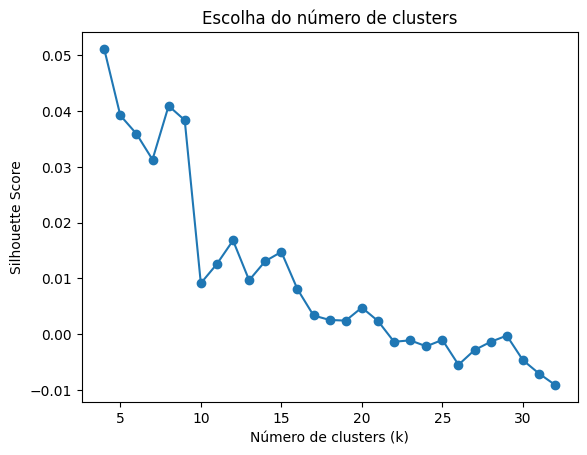

In [22]:
plot_silhouette_scores(silhouette_scores, min_clusters=4)